In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
sys.path.insert(0, "/Users/josephmann/Documents/GitHub/altair/")

In [3]:
import altair as alt

In [4]:
alt.__version__

'2.2.0dev0'

In [5]:
leg_times = [f"TA{c+1}" for c in range(7)]# + ['TotalTime']
leg_times

['TA1', 'TA2', 'TA3', 'TA4', 'TA5', 'TA6', 'TA7']

In [6]:
# need to manually fetch data from Zone 4
o_df = pd.read_csv("over_all_s7_2018.csv", skiprows=271)

In [7]:
oc_df = o_df.rename({"Unnamed: 6":"Bib", "Unnamed: 4":"TeamName", "Finish":"TA7","Unnamed: 2":"TotalTime"}, axis=1)
cum_df =  o_df.rename({"Unnamed: 6":"Bib", "Unnamed: 4":"TeamName", "Finish":"TA7","Unnamed: 2":"TotalTime"}, axis=1)
oc_df = oc_df.drop('Team', axis=1)


oc_df.loc[:,leg_times] =oc_df.loc[:,leg_times].apply(pd.to_timedelta, errors='coerce' )

In [8]:
cum_df[leg_times] = cum_df[leg_times].apply(pd.to_timedelta, errors='coerce' ) +  pd.Timestamp('July 7, 2018')

In [9]:
t_a = oc_df.loc[:,leg_times].values

diff_a = t_a[:,1:] - t_a[:,:-1]

c_a = np.concatenate((t_a[:,[0]], diff_a),axis=1)
oc_df.loc[:,leg_times] = c_a 


In [10]:
oc_df.loc[:,leg_times] = oc_df.loc[:, leg_times].applymap(lambda t: pd.to_timedelta(t,'ns'))
oc_df.loc[:, leg_times] = oc_df.loc[:, leg_times]+ pd.Timestamp('July 7, 2018') 

In [12]:
# single = alt.selection_multi(on='mouseover',   fields=['Bib'], empty='none') # on='mouseover', nearest=True,toggle=True, on='mouseover', 
# single = alt.selection_interval(  fields=['Bib'], empty='none') # on='mouseover', nearest=True,toggle=True, on='mouseover', 


# slider = alt.binding_range(min=700, max=920, step=1)
# select_bib = alt.selection_single(name="Team", fields=['Bib'], bind=slider,  empty='none')
slider = alt.binding_range(min=700, max=920, step=1)
# select_bib = alt.selection_single(name="Team", fields=['Bib'], bind=slider,  empty='none')
select_bib = alt.selection_multi( fields=['Bib'], empty='none')#, bind=slider,  )


ctcum_df = cum_df.melt(
        id_vars=['Bib','TeamName'],
        value_vars=[ 'TA1', 'TA2', 'TA3', 'TA4', 'TA5', 'TA6', 'TA7'],
        var_name='leg',
        value_name='leg_time'
        )

ct_df = oc_df.melt(
        id_vars=['Bib','TeamName'],
        value_vars=[ 'TA1', 'TA2', 'TA3', 'TA4', 'TA5', 'TA6', 'TA7'],
        var_name='leg',
        value_name='leg_time'
        )


ct_ind_cum_df=  pd.merge(
    ct_df, ctcum_df, on=['Bib','leg','TeamName']
).rename(
    {'leg_time_x':'leg_time_i','leg_time_y':'leg_time_c'}, axis=1
).dropna()

leg_base_c = alt.Chart( 
    title="Sinister 7, 2018 Team Leg Times"
).mark_tick(
    orient='vertical', opacity=0.9,# thickness=2,
).encode(
    alt.Y(
        'leg:O',
#         scale=alt.Scale(domain=[690, 930]),
#         axis=None,
        title='Leg'
    ),
    
    tooltip = [
        alt.Tooltip('leg_time_i:T', format="%H:%M:%S", title='Ind Leg Time'),
        alt.Tooltip('leg_time_c:T', format="%H:%M:%S", title='Team Leg Time'),
        'Bib:N',
        'TeamName:N', 
        alt.Tooltip('leg_rank_i:O', title='Individual Leg Rank'),
        alt.Tooltip('leg_rank_c:O', title='Team Leg Rank'),
        ],
    
    size = alt.condition(
        select_bib,
        alt.value(50),
        alt.value(30)),
    
    color = alt.condition(
        select_bib,
        alt.Color('TeamName:N',
#                   scale=alt.Scale(range=["#EA98D2", "#659CCA"]),
                 legend=None),
        alt.value('lightblue')),
    
   opacity = alt.condition(
        select_bib,
        alt.value(1.0),
        alt.value(0.5)),
 
).properties(
    width=1000,
    height=300
).transform_filter(
    "datum.leg_time_c > toDate('2018-07-07 00:00:00.000') |  datum.leg_time_i > toDate('2018-07-07 00:00:00.000')" # this works!
).transform_window(
    window=[alt.WindowFieldDef(op='rank', field='leg_time_i',  **{'as': 'leg_rank_i' })],
    groupby=['leg'],
    frame=[None, None],
    sort= [alt.SortField('leg_time_i', alt.VgComparatorOrder('ascending'))]  #necessary to get ranking per leg correct
).transform_window(
    window=[alt.WindowFieldDef(op='rank', field='leg_time_c',  **{'as': 'leg_rank_c' })],
    groupby=['leg'],
    frame=[None, None],
    sort= [alt.SortField('leg_time_c', alt.VgComparatorOrder('ascending'))]  #necessary to get ranking per leg correct
)


leg_c_c = leg_base_c.encode(
     alt.X(
        'leg_time_c:T', 
        timeUnit="yearmonthdatehoursminutesseconds",
        axis= alt.Axis(format="%H:%M", title="Leg Time")
    ),
).interactive(
    bind_y = False
).add_selection(
    select_bib
).properties(
    title="Sinister 7 Team Leg Times - 2018"
)

leg_i_c = leg_base_c.encode(
    alt.X(
        'leg_time_i:T', 
        timeUnit="hoursminutesseconds",
        axis= alt.Axis(format="%H:%M", title="Leg Time")
    ),
).interactive(
    bind_y = False
).add_selection(
    select_bib
).properties(
    title="Sinister 7 Individual Leg Times - 2018"
)

In [13]:
comb_c = alt.vconcat(leg_c_c,  leg_i_c,  data= ct_ind_cum_df)
# alt.vconcat(leg_c_c,  leg_i_c, data=)

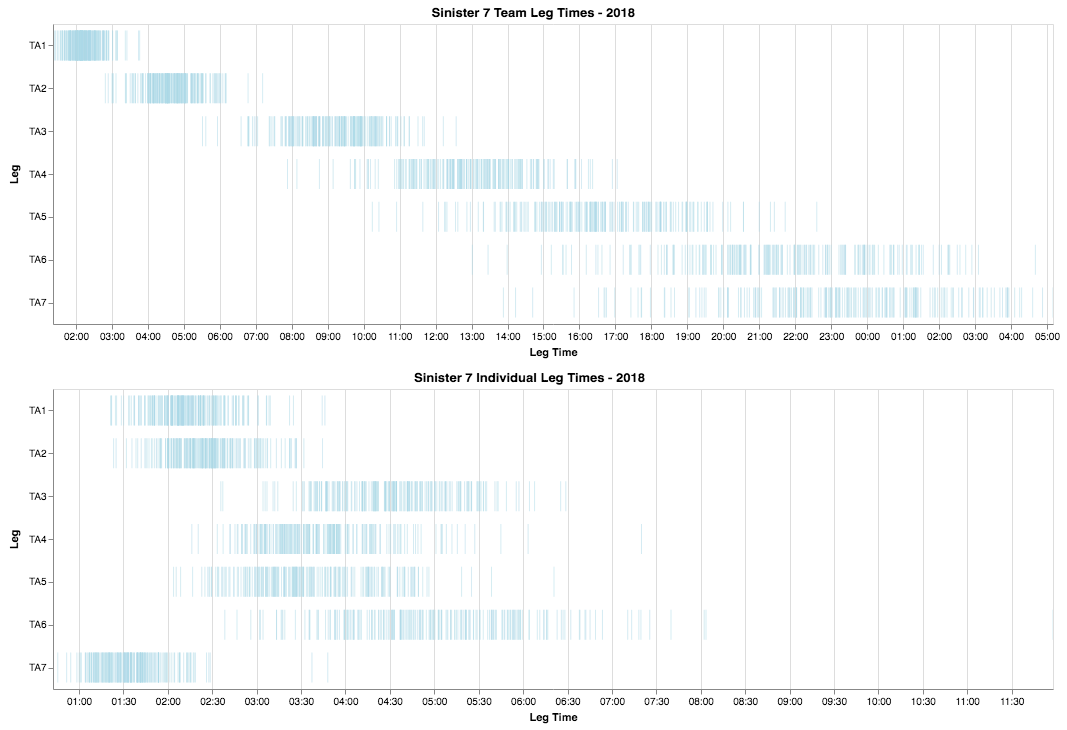

In [14]:
comb_c